In [34]:
library(tidyverse)
library(tidymodels)
set.seed(5)

players <- read_csv("players.csv") |>
                select(played_hours, age) |>
                filter(played_hours > 0)

players_split <- initial_split(players, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

# Create workflow of the KNN-Regression.
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode("regression")

players_recipe <- recipe(played_hours ~ age, data = players) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

players_workflow <- workflow() |>
                        add_recipe(players_recipe) |>
                        add_model(players_spec)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 50 × 7
   neighbors .metric .estimator  mean     n std_err .config              
       <dbl> <chr>   <chr>      <dbl> <int>   <dbl> <chr>                
 1         1 rmse    standard    24.0     5   11.6  Preprocessor1_Model01
 2         2 rmse    standard    23.9     5   11.6  Preprocessor1_Model02
 3         3 rmse    standard    30.4     5    9.56 Preprocessor1_Model03
 4         4 rmse    standard    29.8     5    9.27 Preprocessor1_Model04
 5         5 rmse    standard    28.3     5    9.81 Preprocessor1_Model05
 6         6 rmse    standard    27.3     5   10.2  Preprocessor1_Model06
 7         7 rmse    standard    26.7     5   10.4  Preprocessor1_Model07
 8         8 rmse    standard    26.2     5   10.6  Preprocessor1_Model08
 9         9 rmse    standard    25.8     5   10.8  Preprocessor1_Model09
10        10 rmse    standard    25.8     5   10.8  Preprocessor1_Model10
# ℹ 40 more rows


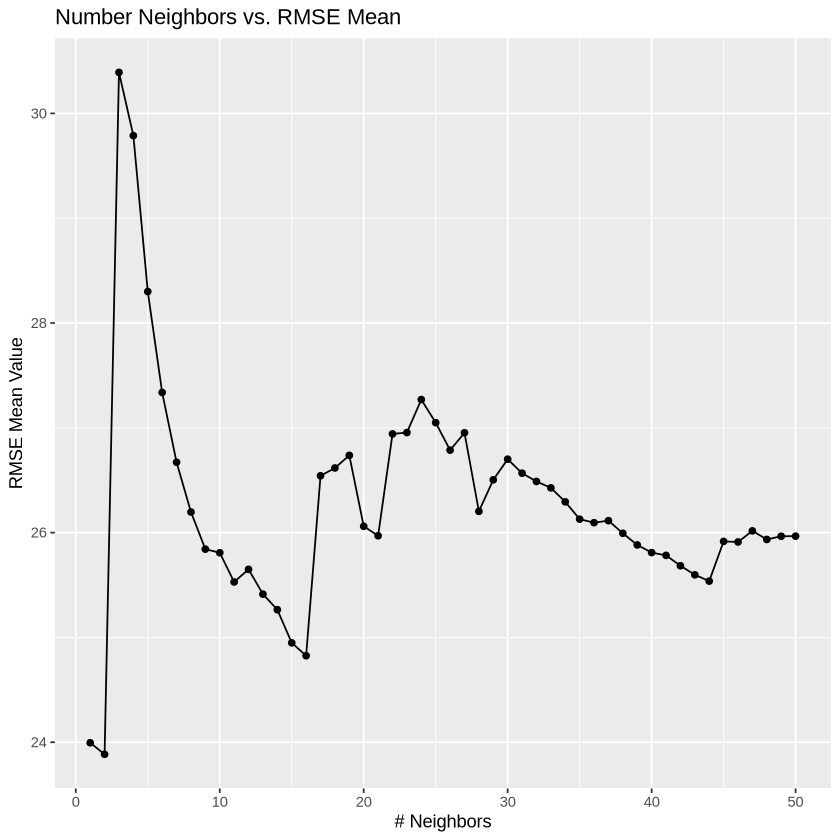

In [35]:
# Find which K value works best
players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)

gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

players_results <- players_workflow |>
                        tune_grid(resamples = players_vfold, grid = gridvals) |>
                        collect_metrics() |>
                        filter(.metric == "rmse")
print(players_results, n=10)

players_results_plot <- players_results |>
                            ggplot(aes(x = neighbors, y = mean)) +
                                    geom_line() +
                                    geom_point() +
                                    labs(x = "# Neighbors", y = "RMSE Mean Value") +
                                    ggtitle("Number Neighbors vs. RMSE Mean")
players_results_plot

In [36]:
# Choose the neighbor with the lowest rmse value.
players_rmse_min <- players_results |>
                        filter(mean == min(mean))
players_rmse_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,rmse,standard,23.88457,5,11.63516,Preprocessor1_Model02


In [37]:
# Calculate the rmse of the neighbors on the testing data set.

players_spec_11 <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
                        set_engine("kknn") |>
                        set_mode("regression")

players_recipe <- recipe(played_hours ~ age, data = players) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

players_workflow_11 <- workflow() |>
                            add_recipe(players_recipe) |>
                            add_model(players_spec_11) |>
                            fit(players_test)

players_summary_test <- players_workflow_11 |>
                            predict(players_test) |>
                            bind_cols(players_test) |>
                            metrics(truth = played_hours, estimate = .pred) |>
                            filter(.metric == "rmse")
players_summary_test


# Results mean that the RMSPE is off by 49.77865 years...

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,35.22315


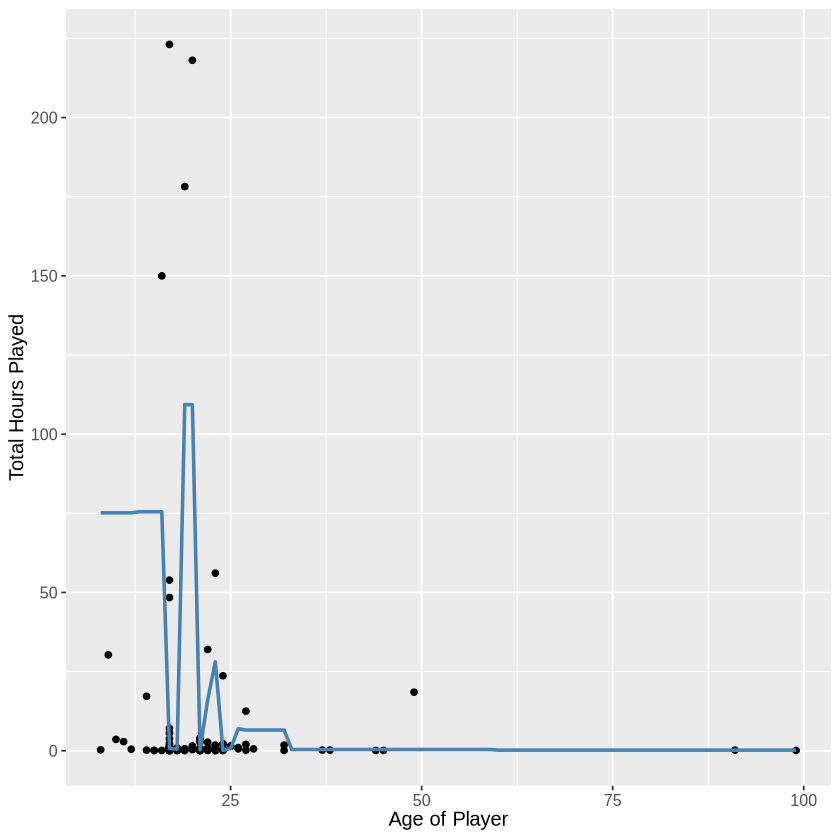

In [38]:
# Plot our final predictor results.

players_prediction_grid <- tibble(age = seq(from = players |> select(age) |> min(), 
                                            to = players |> select(age) |> max(), 
                                            by = 1))

players_predictions <- players_workflow_11 |>
                            predict(players_prediction_grid) |>
                            bind_cols(players_prediction_grid)

players_final_plot <- players |>
                        ggplot(aes(x = age, y = played_hours)) +
                            geom_point() +
                            geom_line(data = players_predictions, 
                                      mapping = aes(x = age, y = .pred), 
                                      color = "steelblue", 
                                      linewidth = 1) +
                            xlab("Age of Player") +
                            ylab("Total Hours Played") +
                            theme(text = element_text(size = 12))
players_final_plot
                    